In [2]:
#Sort out the variables so they are consistent, i.e. does x[1]=x1=xS1?
#PART 1: setting up our functions and importing our modules:
import swiglpk
from swiglpk import *
import matplotlib.pyplot as plt

def myfunction(t,y,v):
    return -v * y

def rungekutta(t,y,h,v):
    k1 = h * myfunction(t,y,v)
    k2 = h * myfunction(t + h * 0.5, y + k1 * 0.5,v)
    k3 = h * myfunction(t + h/2, y + k2 * 0.5,v) 
    k4 = h * myfunction(t + h, y + k3,v)
    y = y + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    t = t + h
    return t,y

In [6]:
#PART 2: initialising variables we will use later
t=0
tmax=2
y=1
h=0.0005
feasible = True
bl = [0,0,0,0,0,0]
ind = intArray(1+3)
val = doubleArray(1+3)
x = [0,0,0,0,0,0]
Zp = []
x1p = []
x2p = []
x3p = []

#PART 3: setting up and solving our initial unchanged problem for the optimal basis the first time
ia = intArray(1+1000); ja = intArray(1+1000);
ar = doubleArray(1+1000);
lp = glp_create_prob();
glp_set_prob_name(lp, "sample");
glp_set_obj_dir(lp, GLP_MAX); #Set the objective direction
glp_add_rows(lp, 3);
glp_set_row_name(lp, 1, "p");
glp_set_row_bnds(lp, 1, GLP_UP, 0.0, 100.0);
glp_set_row_name(lp, 2, "q");
glp_set_row_bnds(lp, 2, GLP_UP, 0.0, 600.0);
glp_set_row_name(lp, 3, "r");
glp_set_row_bnds(lp, 3, GLP_UP, 0.0, 300.0);
glp_add_cols(lp, 3);
glp_set_col_name(lp, 1, "x1");
glp_set_col_bnds(lp, 1, GLP_LO, 0.0, 0.0);
glp_set_obj_coef(lp, 1, 10.0);
glp_set_col_name(lp, 2, "x2");
glp_set_col_bnds(lp, 2, GLP_LO, 0.0, 0.0);
glp_set_obj_coef(lp, 2, 6.0);
glp_set_col_name(lp, 3, "x3");
glp_set_col_bnds(lp, 3, GLP_LO, 0.0, 0.0);
glp_set_obj_coef(lp, 3, 4.0);
ia[1] = 1; ja[1] = 1; ar[1] = 1.0; # a[1,1] = 1
ia[2] = 1; ja[2] = 2; ar[2] = 1.0; # a[1,2] = 1
ia[3] = 1; ja[3] = 3; ar[3] = 1.0; # a[1,3] = 1
ia[4] = 2; ja[4] = 1; ar[4] = 10.0; # a[2,1] = 10
ia[5] = 3; ja[5] = 1; ar[5] = 2.0; # a[3,1] = 2
ia[6] = 2; ja[6] = 2; ar[6] = 4.0; # a[2,2] = 4
ia[7] = 3; ja[7] = 2; ar[7] = 2.0; # a[3,2] = 2
ia[8] = 2; ja[8] = 3; ar[8] = 5.0; # a[2,3] = 5
ia[9] = 3; ja[9] = 3; ar[9] = 6.0; # a[3,3] = 6
glp_load_matrix(lp, 9, ia, ja, ar);
glp_simplex(lp, None);
Z = glp_get_obj_val(lp);
Zmax = Z
x1 = glp_get_col_prim(lp, 1);
x[3] = x1
x2 = glp_get_col_prim(lp, 2);
x[4] = x2
x3 = glp_get_col_prim(lp, 3);
x[5] = x3
print("\nZ = %g; x1 = %g; x2 = %g; x3 = %g\n" % (Z, x1, x2, x3))

#LOOP:
while t < tmax:
    #PART 4: finding out which variables are basic/non-basic upper/lower
    basis = []
    upper = []
    lower = []
    for j in range(0,3):
        bl[j] = glp_get_row_stat(lp,j+1)
            
    for j in range(0,3):
        bl[j+3] = glp_get_col_stat(lp,j+1)

    for j in range(0,6):
        match bl[j]:
            case 0:
                print("error")

            case 1:
                basis = basis + [j+1]

            case 2:
                lower = lower + [j+1]

            case 3:
                upper = upper + [j+1]

    #PART 5: extracting data from simplex tableau so we can calculate xB = E * xN later
    ind = intArray(1+3) #initialise indexes
    val = doubleArray(1+3) #initialise values
    lengths = [0,0,0] #initialise lengths
    indlist = [] #initialise index list
    vallist = [] #initialise value list
    for j in range(0,len(basis)): #for each basic variable
        indcopy = []
        valcopy = []
        leng = glp_eval_tab_row(lp,basis[j],ind,val) #receives the values of the coefficients and their indices
        lengths[j] = leng #stores the number of coefficients
        for k in range(0,leng):
            indc = ind[k+1]
            valc = val[k+1]
            indcopy = indcopy + [indc]
            valcopy = valcopy + [valc]
        indlist.append(indcopy) #stores the indices
        vallist.append(valcopy) #stores the values
        
    #LOOP:            
    while feasible and t<tmax:
        #BONUS: storing data for plotting
        Zp = Zp + [Z]
        x1p = x1p + [x[3]]
        x2p = x2p + [x[4]]
        x3p = x3p + [x[5]]
        #PART 6: run runge-kutta method and update our bounds
        v=Z/Zmax
        t,y = rungekutta(t,y,h,v)
        glp_set_row_bnds(lp, 2, GLP_UP, 0.0, 600.0*y); #This is us changing the bounds
        
        #PART 7: calculating our new x and objective value
        for j in upper:
            if j <= 3:
                x[j-1] = glp_get_row_ub(lp,j)
            else:
                x[j-1] = glp_get_col_ub(lp,j-3)

        
        for j in lower:
            if j <= 3:
                x[j-1] = glp_get_row_lb(lp,j)
            else:
                x[j-1] = glp_get_col_lb(lp,j-3)


        for j in range(0,len(basis)):
            x[basis[j]-1] = 0
            for k in range(0,lengths[j]):
                x[basis[j]-1] += x[indlist[j][k]-1]*vallist[j][k]

        Z = 10 * x[3] + 6 * x[4] + 4 * x[5]

        #PART 8: checking if our new x is feasible, ending the loop if not
        for j in range(0,len(x)):
            if x[j] < 0:
                feasible = False
            elif j <= 2: #2 for 0,1,2 rows
                if x[j] > glp_get_row_ub(lp,j+1):
                    feasible = False
            elif j >= 3: #3 for 3,4,5 columns
                if x[j] > glp_get_row_ub(lp,j-2): #j-2 = 1,2,3
                    feasible = False
            else:
                print("feasible is true")
                
    #end while
    #PART 9: rerunning our simplex method to find a new optimal basis
    glp_load_matrix(lp,9,ia,ja,ar)
    glp_simplex(lp,None)
    Z = glp_get_obj_val(lp)
    x[3] = glp_get_col_prim(lp,1) #these are to get our plotting to work correctly
    x[4] = glp_get_col_prim(lp,2)
    x[5] = glp_get_col_prim(lp,3)
    feasible = True #we reset feasible to be true again
    print(t)
#use knowledge of basic variables to find updated solution
#check updated solution is primal feasible
#if it isn't end loop
#find new optimal solution


Z = 733.333; x1 = 33.3333; x2 = 66.6667; x3 = 0
GLPK Simplex Optimizer 5.0
3 rows, 3 columns, 9 non-zeros

*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (3)
*     2: obj =   7.333333333e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
0.45050000000000034
GLPK Simplex Optimizer 5.0
3 rows, 3 columns, 9 non-zeros
      2: obj =   5.999994620e+02 inf =   1.345e-04 (1)
      3: obj =   5.999987895e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
2.0004999999998354
GLPK Simplex Optimizer 5.0
3 rows, 3 columns, 9 non-zeros
*     3: obj =   2.645092838e+02 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND


In [8]:
#Need to run this before plotting for the first time, sets up the x-axis
tp = []
for i in range(0,len(x1p)):
    tp = tp + [i*h]

Text(0, 0.5, 'Value')

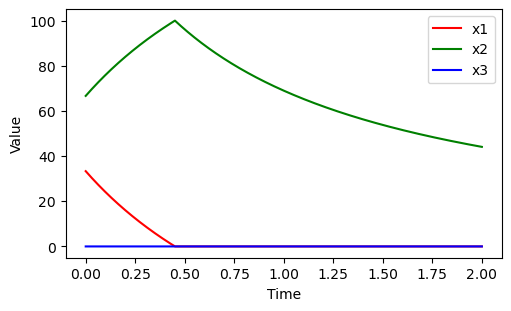

In [10]:
fig, ax = plt.subplots(figsize=(5, 3), layout='constrained')
linesx1 = ax.plot(tp,x1p,"r",label="x1")
linesx2 = ax.plot(tp,x2p,"g",label="x2")
linesx3 = ax.plot(tp,x3p,"b",label="x3")
plt.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Value")

Text(0, 0.5, 'Value')

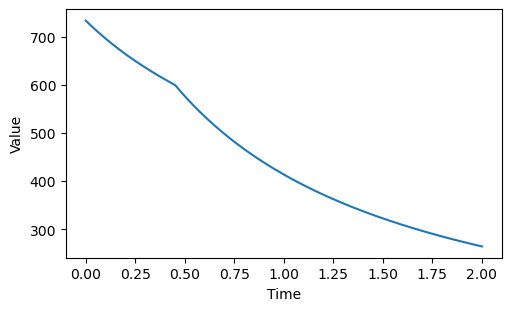

In [12]:
fig, ax = plt.subplots(figsize=(5, 3), layout='constrained')
linesz = ax.plot(tp,Zp,label="Z")
ax.set_xlabel("Time")
ax.set_ylabel("Value")